In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-drought-meteorological-data/soil_data.csv
/kaggle/input/us-drought-meteorological-data/train_timeseries/train_timeseries.csv
/kaggle/input/us-drought-meteorological-data/validation_timeseries/validation_timeseries.csv
/kaggle/input/us-drought-meteorological-data/test_timeseries/test_timeseries.csv


In [2]:
import os
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NeighbourhoodCleaningRule
from imblearn.under_sampling import NearMiss
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.decomposition import PCA, KernelPCA
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import cohen_kappa_score
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import pickle


In [3]:
!pip install PyWavelets

In [4]:

filename = "/kaggle/input/us-drought-meteorological-data/train_timeseries/train_timeseries.csv"
df = pd.read_csv(filename)
df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-01,0.22,100.51,9.65,14.74,13.51,13.51,20.96,11.46,...,14.65,2.20,2.94,1.49,1.46,4.85,6.04,3.23,2.81,NaN
1,1001,2000-01-02,0.20,100.55,10.42,16.69,14.71,14.71,22.80,12.61,...,16.60,2.52,3.43,1.83,1.60,5.33,6.13,3.72,2.41,NaN
2,1001,2000-01-03,3.65,100.15,11.76,18.49,16.52,16.52,22.73,15.32,...,18.41,4.03,5.33,2.66,2.67,7.53,9.52,5.87,3.66,NaN
3,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1.0
4,1001,2000-01-05,0.00,101.15,2.95,3.86,-3.29,-3.20,10.82,-2.66,...,2.65,1.60,2.50,0.52,1.98,2.94,4.85,0.65,4.19,NaN


In [5]:
df = df.sample(frac=0.2, random_state=42).reset_index(drop=True)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3860136 entries, 0 to 3860135
Data columns (total 21 columns):
 #   Column       Dtype  
---  ------       -----  
 0   fips         int64  
 1   date         object 
 2   PRECTOT      float64
 3   PS           float64
 4   QV2M         float64
 5   T2M          float64
 6   T2MDEW       float64
 7   T2MWET       float64
 8   T2M_MAX      float64
 9   T2M_MIN      float64
 10  T2M_RANGE    float64
 11  TS           float64
 12  WS10M        float64
 13  WS10M_MAX    float64
 14  WS10M_MIN    float64
 15  WS10M_RANGE  float64
 16  WS50M        float64
 17  WS50M_MAX    float64
 18  WS50M_MIN    float64
 19  WS50M_RANGE  float64
 20  score        float64
dtypes: float64(19), int64(1), object(1)
memory usage: 618.5+ MB


In [7]:
df.isnull().sum()

fips                 0
date                 0
PRECTOT              0
PS                   0
QV2M                 0
T2M                  0
T2MDEW               0
T2MWET               0
T2M_MAX              0
T2M_MIN              0
T2M_RANGE            0
TS                   0
WS10M                0
WS10M_MAX            0
WS10M_MIN            0
WS10M_RANGE          0
WS50M                0
WS50M_MAX            0
WS50M_MIN            0
WS50M_RANGE          0
score          3309637
dtype: int64

In [8]:
df = df.dropna()
df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

In [9]:
df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score          float64
dtype: object

In [10]:
df['year'] = pd.DatetimeIndex(df['date']).year
df['month'] = pd.DatetimeIndex(df['date']).month
df['day'] = pd.DatetimeIndex(df['date']).day
df['score'] = df['score'].round().astype(int)
df.dtypes

fips             int64
date            object
PRECTOT        float64
PS             float64
QV2M           float64
T2M            float64
T2MDEW         float64
T2MWET         float64
T2M_MAX        float64
T2M_MIN        float64
T2M_RANGE      float64
TS             float64
WS10M          float64
WS10M_MAX      float64
WS10M_MIN      float64
WS10M_RANGE    float64
WS50M          float64
WS50M_MAX      float64
WS50M_MIN      float64
WS50M_RANGE    float64
score            int64
year             int32
month            int32
day              int32
dtype: object

In [11]:
df['fips'].nunique()


3108

In [12]:
df['score'].round().value_counts()

score
0    328983
1     93253
2     59245
3     39681
4     21400
5      7937
Name: count, dtype: int64

<Axes: xlabel='score'>

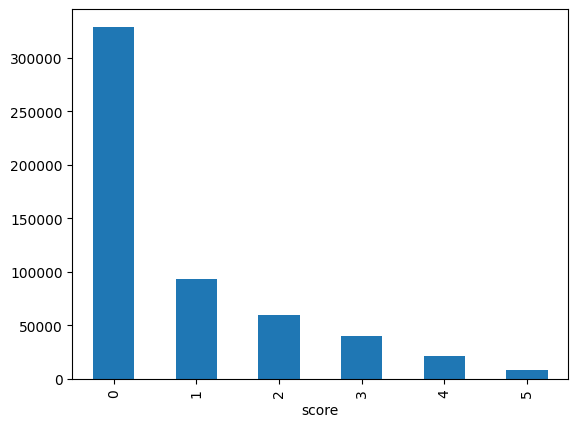

In [13]:
df['score'].round().value_counts().plot(kind='bar')


In [14]:
display(df.describe())  # For numeric columns
display(df.describe(include=['object']))  # For categorical columns
numeric_df = df.select_dtypes(include=['number'])
print("\nSkewness: \n", numeric_df.skew(axis=0, skipna=True))
print("\nKurtosis: \n", numeric_df.kurtosis(axis=0, skipna=True))

,fips,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,...,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score,year,month,day
count,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,...,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000,550499.000000
mean,30653.323786,2.712732,96.639188,7.873772,12.907442,7.044491,7.080144,18.774557,7.529370,11.245190,...,1.920763,3.287664,5.536031,7.833733,3.123058,4.710667,0.828468,2007.999876,6.529498,15.687752
std,14991.178153,6.255889,5.449056,4.721648,10.966664,10.195076,10.141045,11.600257,10.613139,4.042122,...,1.342170,1.949346,2.298976,2.842144,2.109910,2.188461,1.242854,4.902566,3.447521,8.804949
min,1001.000000,0.000000,66.930000,0.150000,-34.630000,-34.950000,-34.750000,-29.710000,-39.830000,0.160000,...,0.000000,0.290000,0.600000,1.000000,0.000000,0.470000,0.000000,2000.000000,1.000000,1.000000
25%,19039.000000,0.000000,95.810000,3.810000,4.580000,-0.890000,-0.850000,10.350000,-0.570000,8.370000,...,0.960000,1.820000,3.820000,5.710000,1.450000,3.140000,0.000000,2004.000000,4.000000,8.000000
50%,29213.000000,0.190000,98.280000,6.940000,14.230000,7.790000,7.800000,20.650000,8.270000,11.190000,...,1.660000,2.820000,5.150000,7.350000,2.770000,4.270000,0.000000,2008.000000,7.000000,16.000000
75%,46007.000000,2.260000,99.950000,11.450000,22.005000,15.660000,15.660000,27.980000,16.290000,14.080000,...,2.560000,4.280000,6.880000,9.500000,4.390000,5.820000,1.000000,2012.000000,10.000000,23.000000
max,56043.000000,150.110000,103.750000,21.900000,38.810000,26.540000,26.540000,46.540000,32.200000,29.990000,...,14.110000,17.240000,21.530000,25.560000,17.440000,21.310000,5.000000,2016.000000,12.000000,31.000000


,date
count,550499
unique,887
top,2005-12-13
freq,689



Skewness: 
 fips          -0.078398
PRECTOT        4.597546
PS            -2.125215
QV2M           0.527975
T2M           -0.425159
T2MDEW        -0.299960
T2MWET        -0.286338
T2M_MAX       -0.466716
T2M_MIN       -0.364095
T2M_RANGE      0.094991
TS            -0.395231
WS10M          1.109830
WS10M_MAX      0.932467
WS10M_MIN      1.401370
WS10M_RANGE    1.290582
WS50M          0.859984
WS50M_MAX      0.902053
WS50M_MIN      0.859803
WS50M_RANGE    1.223077
score          1.489176
year          -0.000493
month         -0.011914
day            0.005887
dtype: float64

Kurtosis: 
 fips           -1.100649
PRECTOT        33.382041
PS              4.781119
QV2M           -0.783230
T2M            -0.560016
T2MDEW         -0.738758
T2MWET         -0.763269
T2M_MAX        -0.513779
T2M_MIN        -0.454235
T2M_RANGE      -0.311407
TS             -0.542650
WS10M           1.409198
WS10M_MAX       0.708836
WS10M_MIN       3.156484
WS10M_RANGE     2.090108
WS50M           0.812229
WS50M_M

In [15]:
measures_column_list = ['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']
drought_df_measures = df[['PRECTOT','PS','QV2M','T2M','T2MDEW','T2MWET','T2M_MAX','T2M_MIN','T2M_RANGE','TS','WS10M','WS10M_MAX','WS10M_MIN','WS10M_RANGE','WS50M','WS50M_MAX','WS50M_MIN','WS50M_RANGE']]

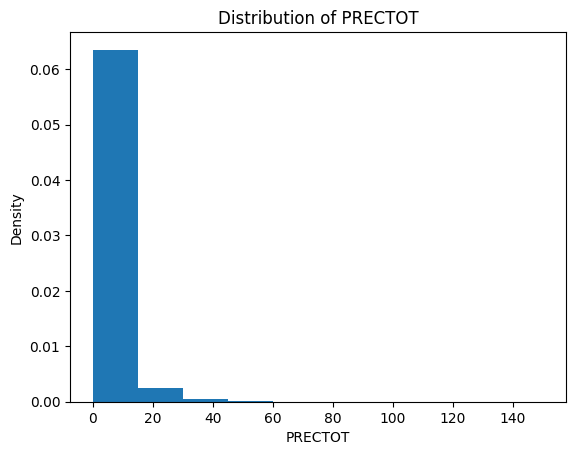

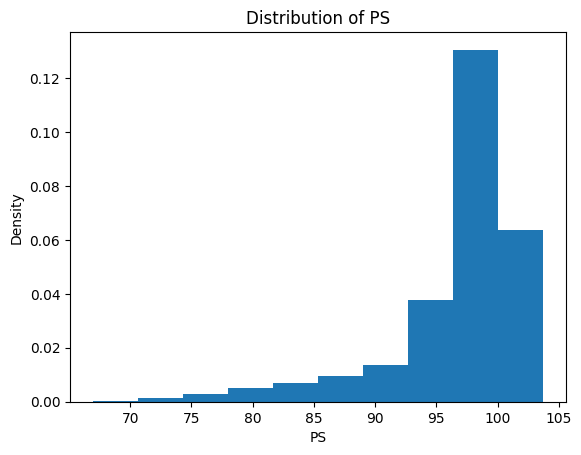

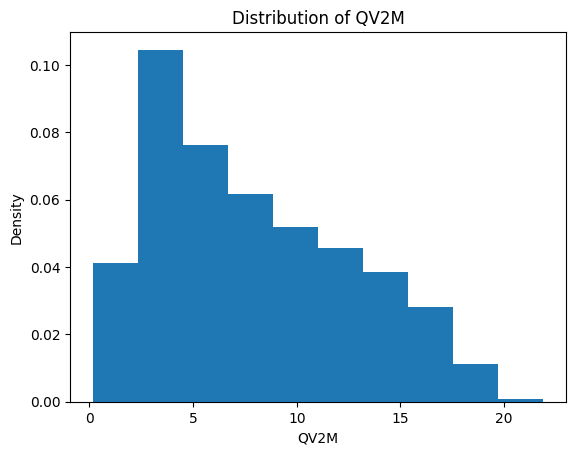

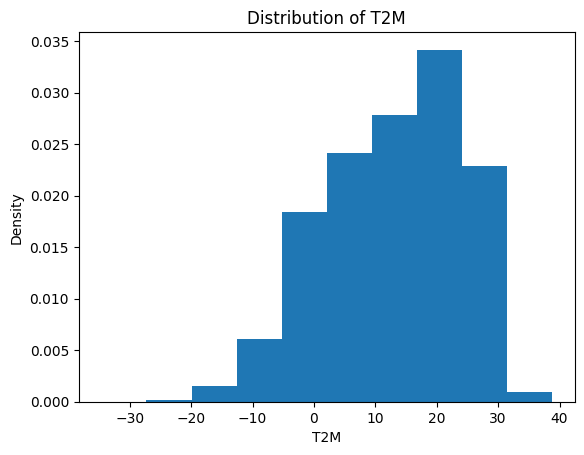

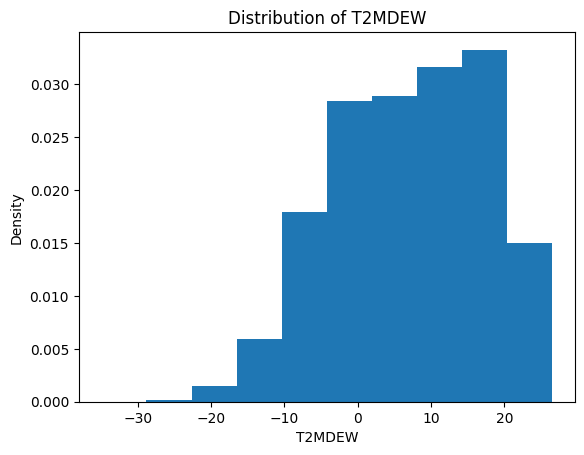

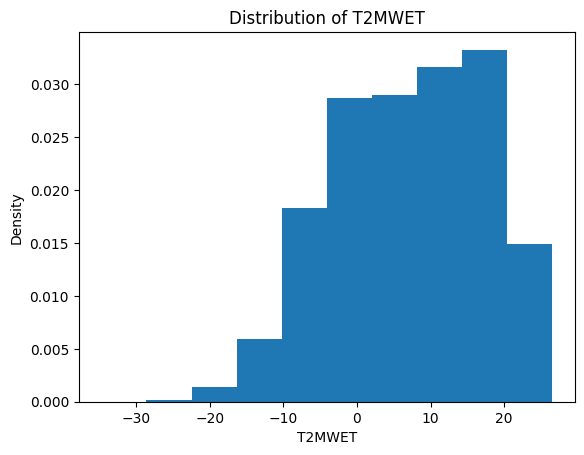

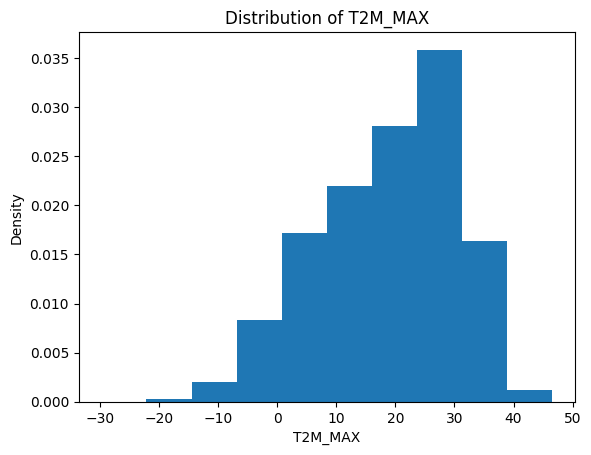

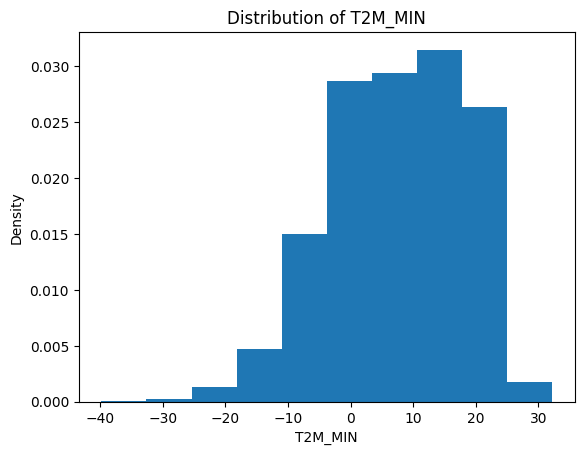

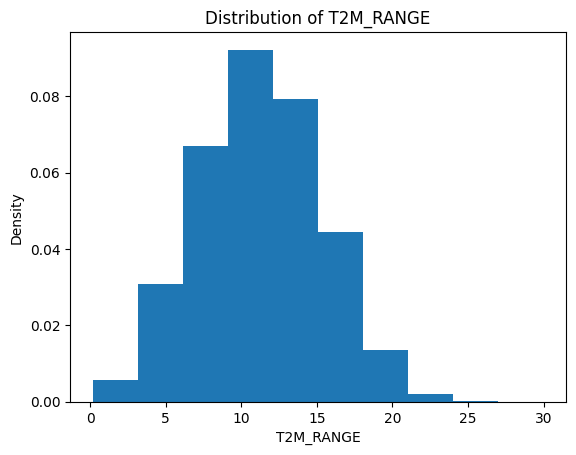

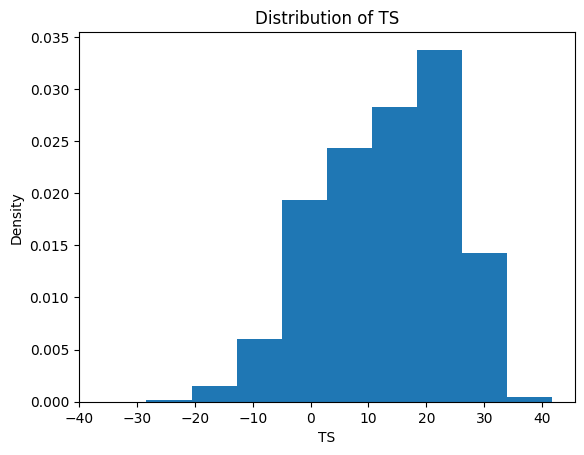

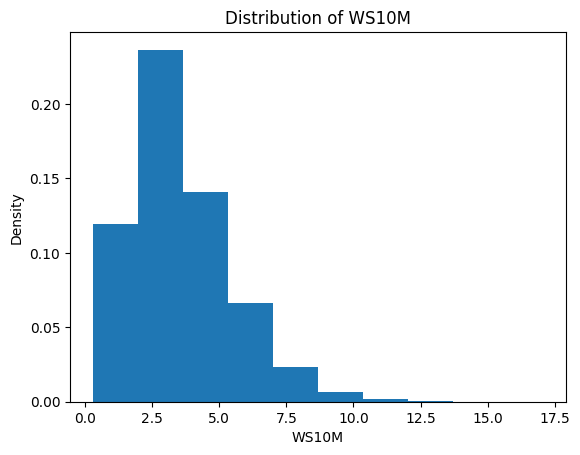

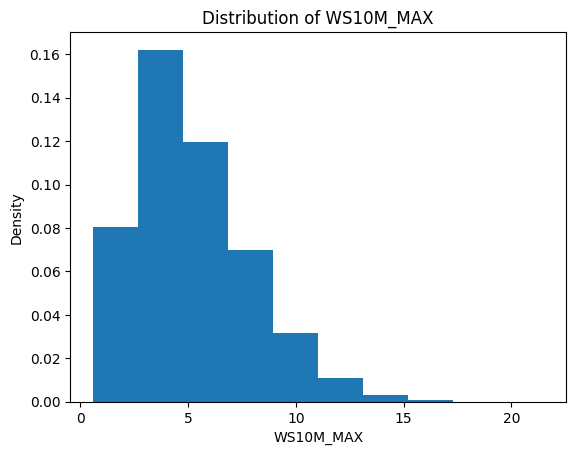

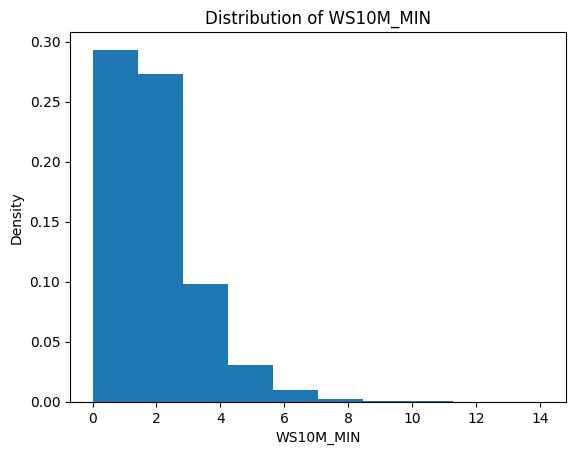

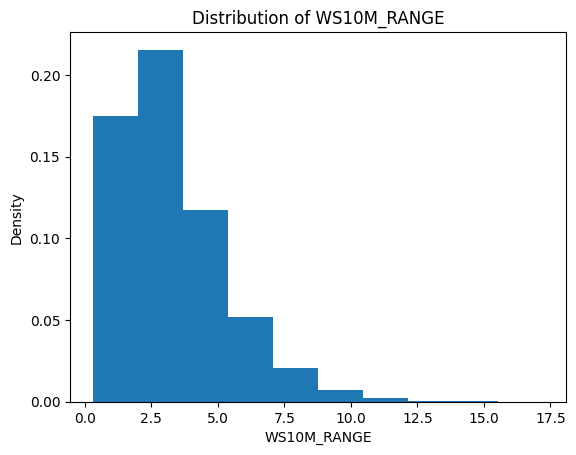

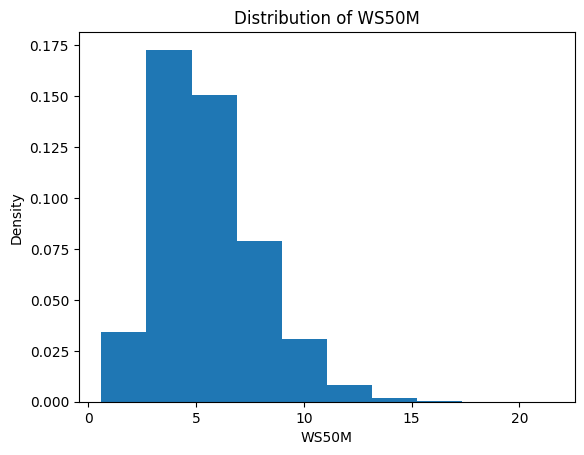

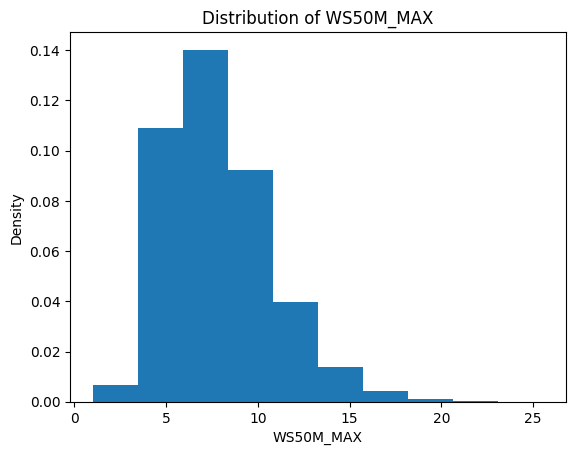

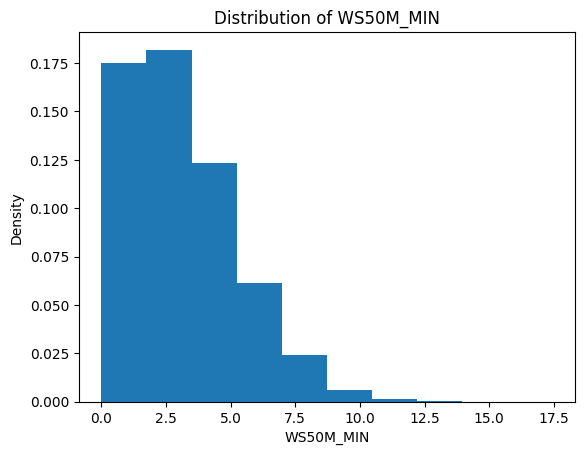

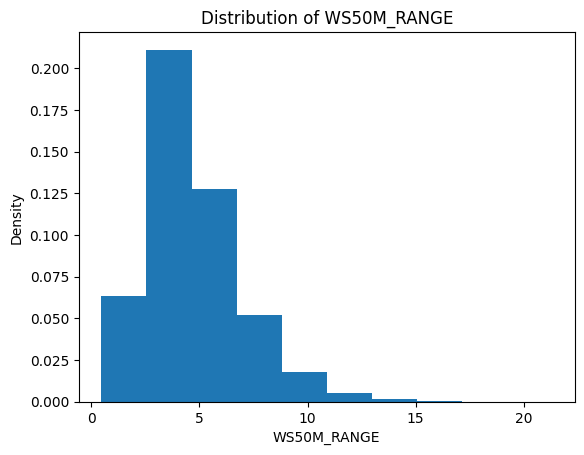

In [16]:
for col_name in measures_column_list:
    plt.figure()
    plt.hist(drought_df_measures[col_name], density = True)
    x_name = col_name
    plt.xlabel(x_name)
    y_name = 'Density'
    plt.ylabel(y_name)
    plt.title('Distribution of {x_name}'.format(x_name=x_name))

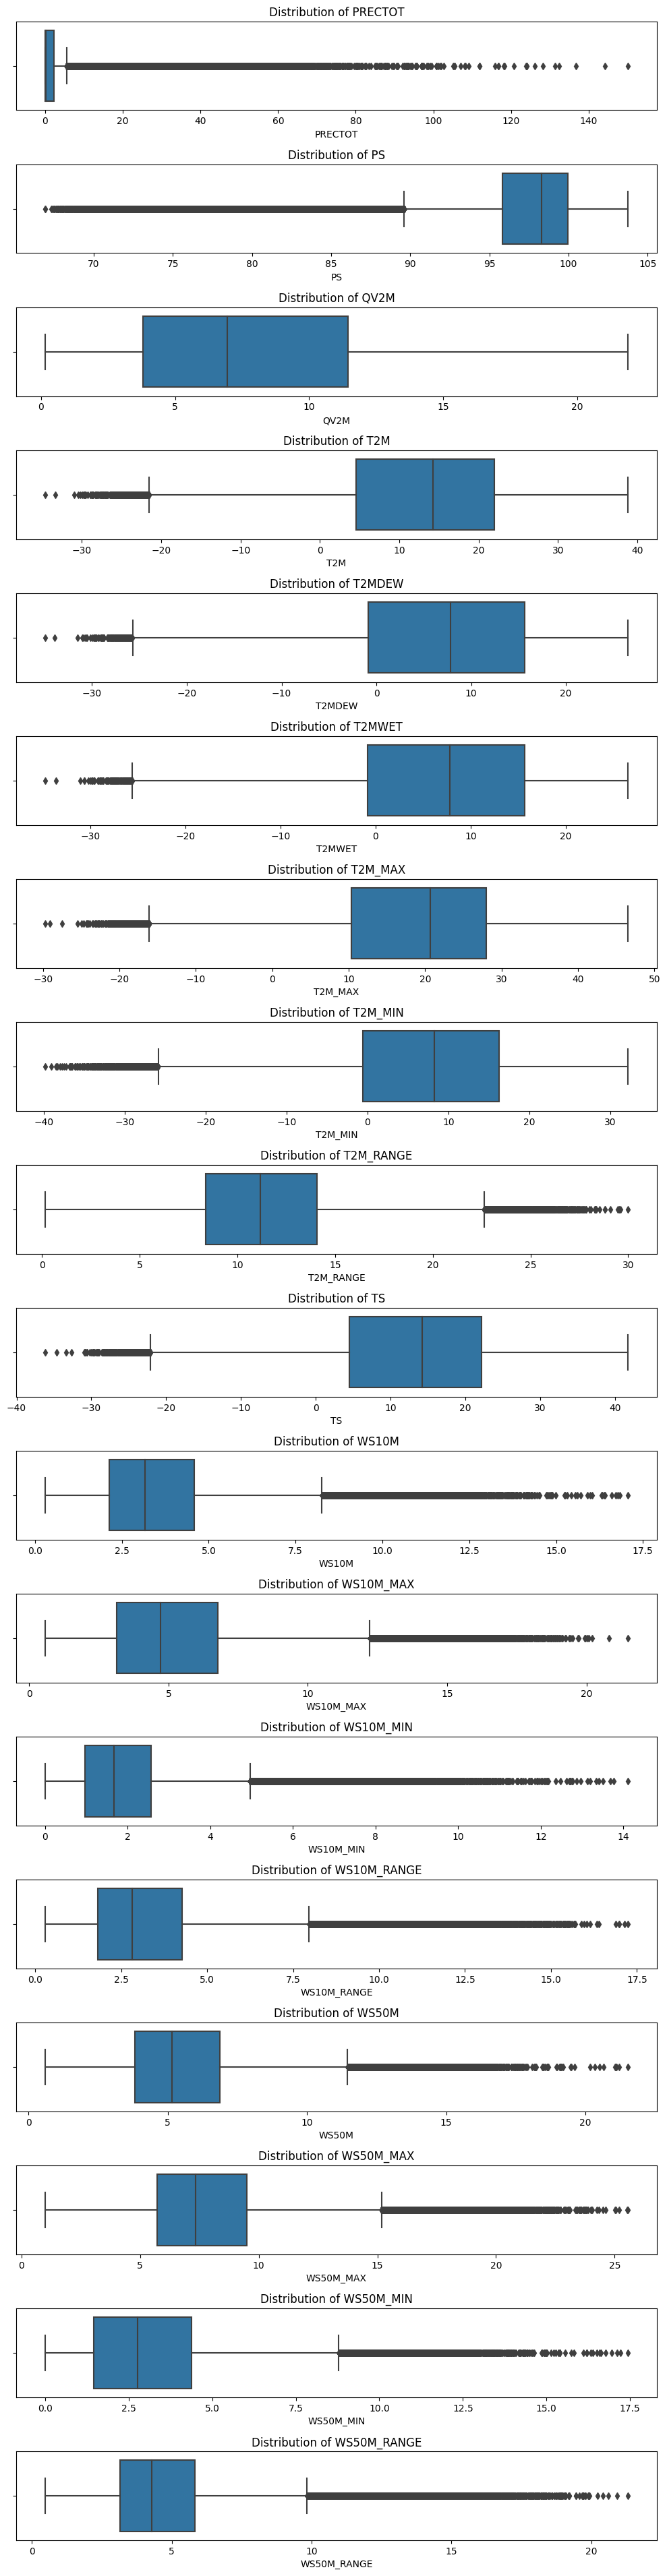

In [17]:
plt.figure(figsize=(10,40))
for x in (range(1,19)):
    plt.subplot(19,1,x)
    sns.boxplot(x =  drought_df_measures.columns[x-1], data=drought_df_measures)
    x_name = drought_df_measures.columns[x-1]
    plt.title(f'Distribution of {x_name}')         
plt.tight_layout()


In [18]:
print('Total rows = ',len(drought_df_measures.index))
for i in drought_df_measures.select_dtypes(exclude = ['object']).columns:
    print ('Number of values beyong standard outlier limit in ', i)
    print(len(drought_df_measures[(drought_df_measures[i] > drought_df_measures[i].mean() + 3*drought_df_measures[i].std()) | (drought_df_measures[i] < drought_df_measures[i].mean() - 3*drought_df_measures[i].std())]))

Total rows =  550499
Number of values beyong standard outlier limit in  PRECTOT
13078
Number of values beyong standard outlier limit in  PS
14523
Number of values beyong standard outlier limit in  QV2M
0
Number of values beyong standard outlier limit in  T2M
893
Number of values beyong standard outlier limit in  T2MDEW
390
Number of values beyong standard outlier limit in  T2MWET
340
Number of values beyong standard outlier limit in  T2M_MAX
672
Number of values beyong standard outlier limit in  T2M_MIN
1370
Number of values beyong standard outlier limit in  T2M_RANGE
736
Number of values beyong standard outlier limit in  TS
917
Number of values beyong standard outlier limit in  WS10M
5946
Number of values beyong standard outlier limit in  WS10M_MAX
4709
Number of values beyong standard outlier limit in  WS10M_MIN
8023
Number of values beyong standard outlier limit in  WS10M_RANGE
7203
Number of values beyong standard outlier limit in  WS50M
4576
Number of values beyong standard outlie

In [19]:
columns_to_filter = ['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 
                     'T2M_MAX', 'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 
                     'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 'WS50M', 
                     'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE']

for col in columns_to_filter:
    df = df[(df[col] <= df[col].mean() + 3*df[col].std()) & 
            (df[col] >= df[col].mean() - 3*df[col].std())]

print('Total rows after outlier removal:', len(df))


Total rows after outlier removal: 494127


In [20]:
categorical_column_list = ['score', 'year', 'month', 'day']
df_categorical = df[['score', 'year', 'month', 'day']]


<Figure size 1000x4000 with 0 Axes>

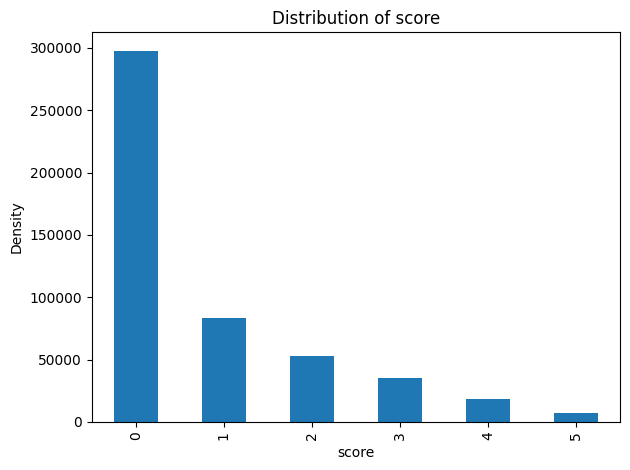

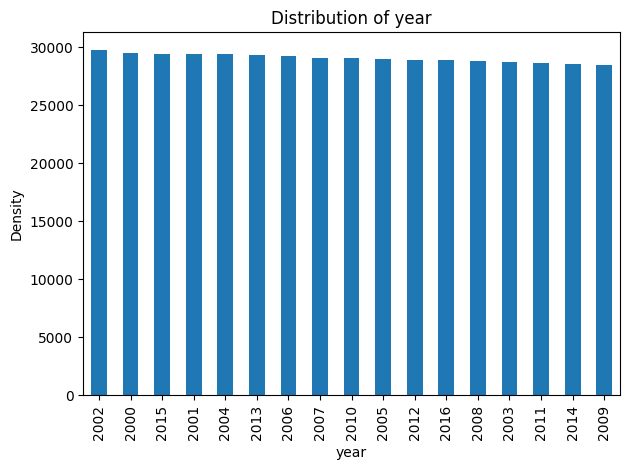

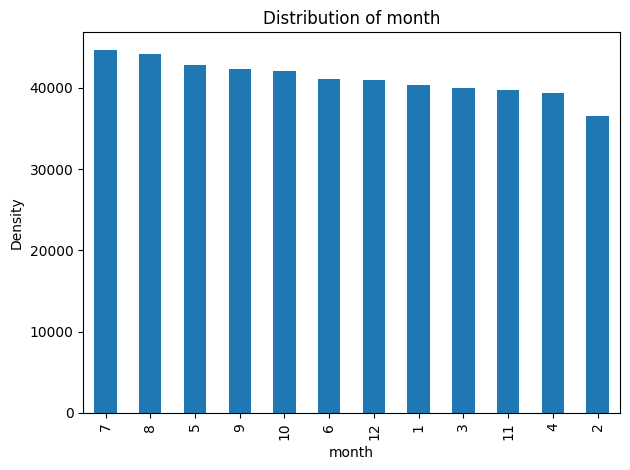

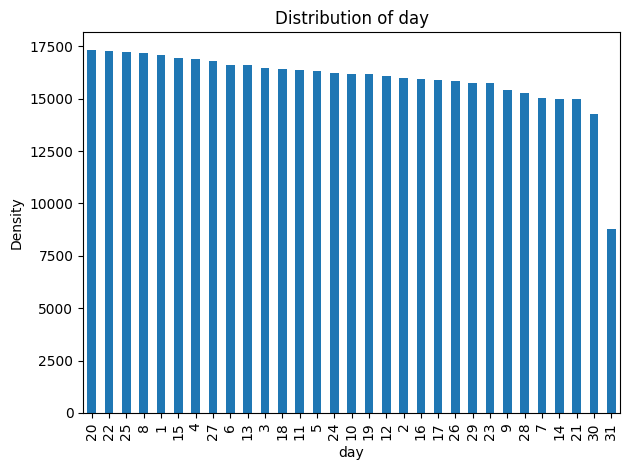

In [21]:
plt.figure(figsize=(10, 40))
for col_name in categorical_column_list:
    plt.figure()  # Create a new figure for each plot
    df_categorical[col_name].value_counts().plot(kind='bar')  # Use df_categorical
    plt.xlabel(col_name)  # Set x-axis label
    plt.ylabel('Density')  # Set y-axis label
    plt.title(f'Distribution of {col_name}')  # Use f-string for formatting
    plt.tight_layout()  # Adjust layout to prevent overlap


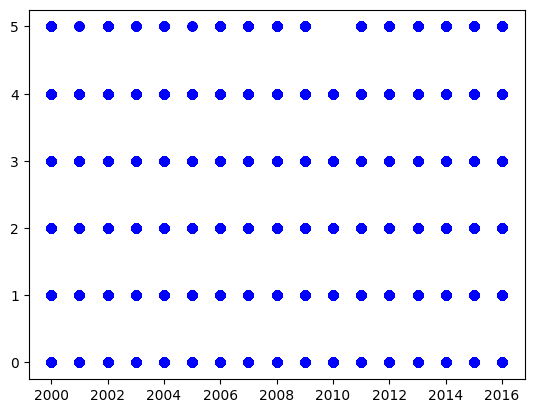

In [22]:
plt.scatter(df['year'], df['score'], c ="blue")
plt.show()

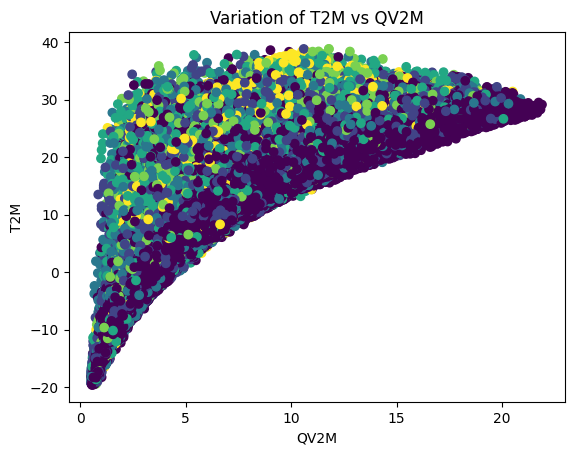

In [23]:
plt.scatter(df['QV2M'], df['T2M'], c =df['score'])
plt.xlabel('QV2M')
plt.ylabel('T2M')
plt.title('Variation of T2M vs QV2M')
plt.show()

In [24]:
independent_variables = df.drop(columns=['score', 'fips', 'date'])
independent_variables.head()

,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,...,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,year,month,day
5,15.39,93.41,9.04,13.15,11.42,11.42,14.83,11.61,3.22,13.12,...,3.68,1.07,2.61,4.37,6.34,2.56,3.79,2011,10,11
9,4.13,96.49,11.29,19.52,15.24,15.24,25.54,13.90,11.65,19.51,...,2.21,1.32,0.89,4.12,4.89,2.24,2.65,2001,7,10
10,0.05,101.93,16.40,24.79,22.11,22.11,27.73,22.47,5.27,24.10,...,6.44,4.56,1.88,7.61,9.33,6.25,3.08,2006,7,11
13,21.18,100.47,8.39,11.90,10.97,10.97,17.10,3.50,13.60,11.65,...,5.83,1.84,3.99,6.60,8.59,3.89,4.70,2006,1,10
14,0.05,84.37,8.00,23.38,7.95,7.96,30.91,16.21,14.71,22.68,...,2.69,0.86,1.83,2.64,4.54,1.14,3.41,2015,8,11


In [25]:
target = df['score'].reset_index(drop=True)
target.head()

0    0
1    0
2    0
3    1
4    2
Name: score, dtype: int64

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_plot = drought_df_measures.corr()

# Display styled correlation matrix
display(correlation_plot.style.background_gradient(cmap='RdYlGn'))


,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,T2M_RANGE,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE
PRECTOT,1.000000,0.069301,0.244933,0.093066,0.230997,0.230936,0.026204,0.144665,-0.304640,0.089322,0.051197,0.062166,0.025063,0.066073,0.070474,0.080835,0.059405,0.047704
PS,0.069301,1.000000,0.282719,0.164477,0.341653,0.341676,0.112172,0.208791,-0.226293,0.163944,-0.081899,-0.137317,0.022592,-0.199603,-0.044262,-0.093229,0.035737,-0.155527
QV2M,0.244933,0.282719,1.000000,0.869961,0.959475,0.960523,0.803761,0.906006,-0.072176,0.862279,-0.224380,-0.255026,-0.107690,-0.267671,-0.205546,-0.249375,-0.080576,-0.246182
T2M,0.093066,0.164477,0.869961,1.000000,0.913258,0.913949,0.983301,0.981597,0.244601,0.997522,-0.206926,-0.218869,-0.124410,-0.207694,-0.192852,-0.205903,-0.111494,-0.159913
T2MDEW,0.230997,0.341653,0.959475,0.913258,1.000000,0.999970,0.854161,0.939790,-0.016238,0.904876,-0.237426,-0.267464,-0.114706,-0.279509,-0.203913,-0.244934,-0.081188,-0.239821
T2MWET,0.230936,0.341676,0.960523,0.913949,0.999970,1.000000,0.854850,0.940489,-0.016096,0.905608,-0.237080,-0.267053,-0.114659,-0.278991,-0.203805,-0.244747,-0.081261,-0.239508
T2M_MAX,0.026204,0.112172,0.803761,0.983301,0.854161,0.854850,1.000000,0.937601,0.408043,0.980062,-0.215998,-0.220501,-0.141148,-0.198357,-0.195523,-0.195765,-0.132309,-0.126680
T2M_MIN,0.144665,0.208791,0.906006,0.981597,0.939790,0.940489,0.937601,1.000000,0.065134,0.979118,-0.205257,-0.224366,-0.111658,-0.223843,-0.197466,-0.225070,-0.095372,-0.200349
T2M_RANGE,-0.304640,-0.226293,-0.072176,0.244601,-0.016238,-0.016096,0.408043,0.065134,1.000000,0.241815,-0.080949,-0.043701,-0.111902,0.018475,-0.042648,0.029135,-0.129296,0.162492
TS,0.089322,0.163944,0.862279,0.997522,0.904876,0.905608,0.980062,0.979118,0.241815,1.000000,-0.188854,-0.201458,-0.109144,-0.194868,-0.180327,-0.192905,-0.101152,-0.153003


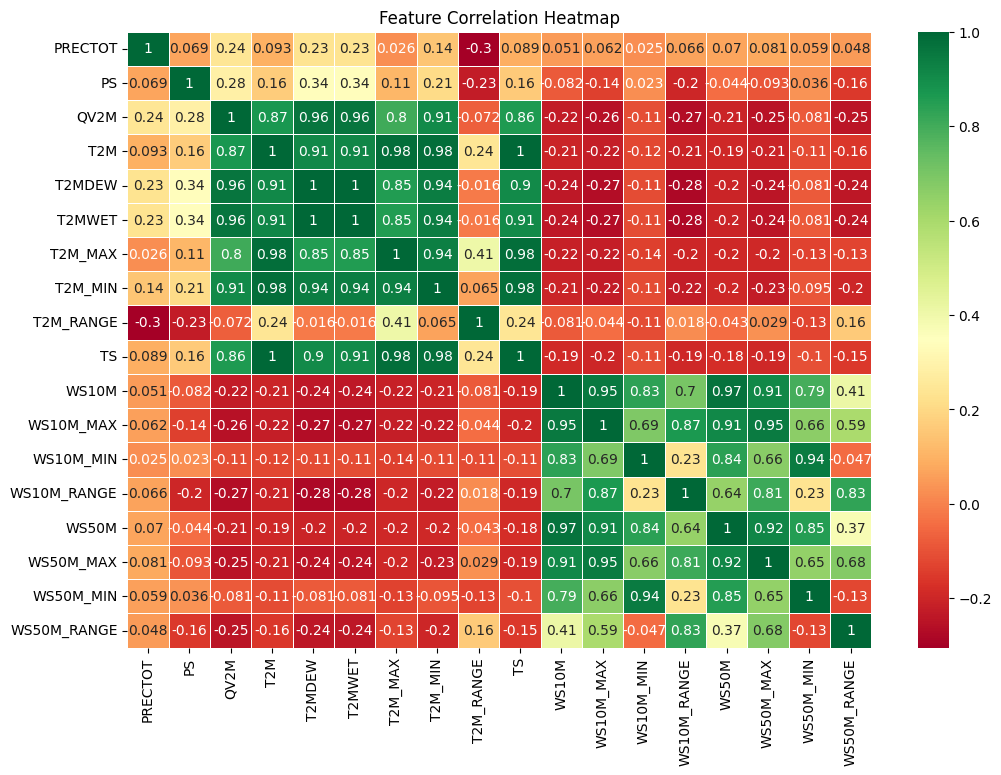

In [27]:

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_plot, annot=True, cmap='RdYlGn', linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.show()

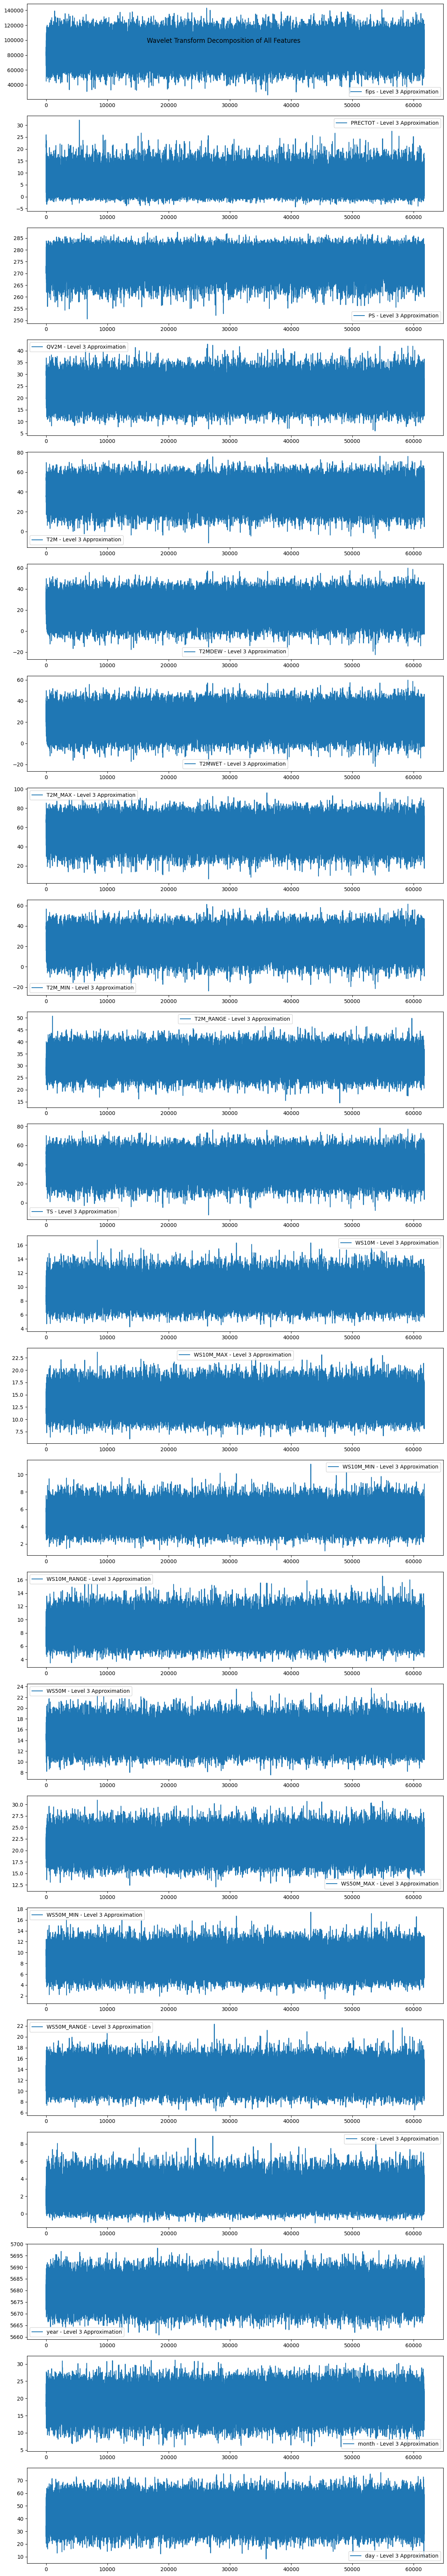

In [28]:
import pywt

# Selecting only numerical columns for wavelet transform
numerical_columns = df.select_dtypes(include=[np.number]).columns

wavelet = 'db4'  # Daubechies wavelet
level = 3  # Decomposition level

wavelet_coeffs = {}  # Dictionary to store coefficients for each feature

plt.figure(figsize=(12, len(numerical_columns) * 3))
for idx, col in enumerate(numerical_columns):
    signal = df[col].values  # Extract column values
    coeffs = pywt.wavedec(signal, wavelet, level=level)  
    wavelet_coeffs[col] = coeffs  # Store coefficients for reconstruction if needed

    # Plotting the decomposed wavelet coefficients
    plt.subplot(len(numerical_columns), 1, idx+1)
    plt.plot(coeffs[0], label=f'{col} - Level {level} Approximation')
    plt.legend()

plt.suptitle('Wavelet Transform Decomposition of All Features')
plt.tight_layout()
plt.show()


In [29]:
reconstructed_signals = {}
for col in numerical_columns:
    reconstructed_signals[col] = pywt.waverec(wavelet_coeffs[col], wavelet)[:len(df)]

# Convert back to DataFrame
df_wavelet = pd.DataFrame(reconstructed_signals)
df_wavelet.columns = [f'{col}_wavelet' for col in df_wavelet.columns]  # Rename columns to indicate wavelet transformation

# Add wavelet-transformed features to the original dataset
df_final = pd.concat([df, df_wavelet], axis=1)
df_final.head()


,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,WS10M_MIN_wavelet,WS10M_RANGE_wavelet,WS50M_wavelet,WS50M_MAX_wavelet,WS50M_MIN_wavelet,WS50M_RANGE_wavelet,score_wavelet,year_wavelet,month_wavelet,day_wavelet
5,47171.0,2011-10-11,15.39,93.41,9.04,13.15,11.42,11.42,14.83,11.61,...,1.38,2.81,5.56,7.52,2.12,5.40,4.440892e-16,2005.0,5.0,24.0
9,36095.0,2001-07-10,4.13,96.49,11.29,19.52,15.24,15.24,25.54,13.90,...,1.07,6.85,7.28,10.08,2.06,8.02,2.220446e-16,2015.0,8.0,18.0
10,10005.0,2006-07-11,0.05,101.93,16.40,24.79,22.11,22.11,27.73,22.47,...,2.37,2.86,6.69,8.46,4.84,3.63,3.000000e+00,2007.0,10.0,23.0
13,28009.0,2006-01-10,21.18,100.47,8.39,11.90,10.97,10.97,17.10,3.50,...,0.49,0.81,2.16,3.40,0.79,2.61,4.000000e+00,2002.0,9.0,17.0
14,30007.0,2015-08-11,0.05,84.37,8.00,23.38,7.95,7.96,30.91,16.21,...,0.47,1.63,2.99,5.07,0.91,4.16,4.440892e-16,2001.0,10.0,2.0


In [30]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.drop(columns=['date', 'fips']))  # Excluding non-numeric columns

In [31]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])  # Selecting seq_length time steps
        y.append(data[i+seq_length, -1])  # Predicting the 'score' value
    return np.array(X), np.array(y)

In [32]:
seq_length = 30  # Using past 30 days for prediction
X, y = create_sequences(scaled_data, seq_length)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Training Data Shape: ", X_train.shape)
print("Testing Data Shape: ", X_test.shape)

Training Data Shape:  (395277, 30, 22)
Testing Data Shape:  (98820, 30, 22)


In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(seq_length, X.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')  # Regression Output
])

In [35]:
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 64)              │          22,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,233 (137.63 KB)

 Trainable params: 35,233 (137.63 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
history = model.fit(
    X_train, y_train,  # Training data
    validation_data=(X_test, y_test),  # Validation data
    epochs=20,  # You can adjust based on performance
    batch_size=64,  # Reduce if memory issues occur
    verbose=1  # Shows training progress
)

Epoch 1/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 203s 32ms/step - loss: 0.0877 - val_loss: 0.0861
Epoch 2/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 202s 33ms/step - loss: 0.0864 - val_loss: 0.0863
Epoch 3/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 205s 33ms/step - loss: 0.0860 - val_loss: 0.0861
Epoch 4/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 203s 33ms/step - loss: 0.0861 - val_loss: 0.0861
Epoch 5/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - loss: 0.0860 - val_loss: 0.0863
Epoch 6/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - loss: 0.0860 - val_loss: 0.0861
Epoch 7/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - loss: 0.0860 - val_loss: 0.0861
Epoch 8/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - loss: 0.0864 - val_loss: 0.0862
Epoch 9/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 199s 32ms/step - loss: 0.0861 - val_loss: 0.0862
Epoch 10/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 200s 32ms/step - loss: 0.0862 - val_loss: 0.0861
Epoch 11/20
6177/6177 ━━━━━━━━━━━━━━━━━━━━ 201s 32ms/step - loss: 0.0862 - val_loss: 0.08

In [42]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

if 'X_test_seq' not in locals():
    X_test_seq = X_test  # Assign correct test data

if 'y_test_seq' not in locals():
    y_test_seq = y_test 

# Extract LSTM predictions
y_pred_lstm = model.predict(X_test_seq)

# Compute residual errors
errors = y_test_seq - y_pred_lstm.flatten()

# Reshape input for RandomForest
X_test_rf = X_test_seq.reshape(X_test_seq.shape[0], -1)  # Flatten sequences

# Reduce dataset size if training takes too long
subset_size = min(5000, X_test_rf.shape[0])  # Use max 5000 samples
X_subset = X_test_rf[:subset_size]
errors_subset = errors[:subset_size]

# Train Random Forest on residual errors (Optimized)
rf = RandomForestRegressor(n_estimators=20,  # Reduced from 100 to 20
                           random_state=42, 
                           n_jobs=-1)  # Use all CPU cores
rf.fit(X_subset, errors_subset)

# Correct LSTM predictions
error_correction = rf.predict(X_test_rf)
y_pred_corrected = y_pred_lstm.flatten() + error_correction

# Evaluate Model
mse_lstm = mean_squared_error(y_test_seq, y_pred_lstm.flatten())
mse_corrected = mean_squared_error(y_test_seq, y_pred_corrected)

print("LSTM MSE:", mse_lstm)
print("Hybrid Model (LSTM + RF) MSE:", mse_corrected)


3089/3089 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step
LSTM MSE: 0.08613628800805101
Hybrid Model (LSTM + RF) MSE: 0.0867172417294395


In [43]:

print("Residual Error Mean:", np.mean(errors))
print("Residual Error Std:", np.std(errors))


Residual Error Mean: -0.006817324521598214
Residual Error Std: 0.2934106543641833


In [44]:
rf.fit(y_pred_lstm.reshape(-1, 1), errors)


RandomForestRegressor(n_estimators=20, n_jobs=-1, random_state=42)

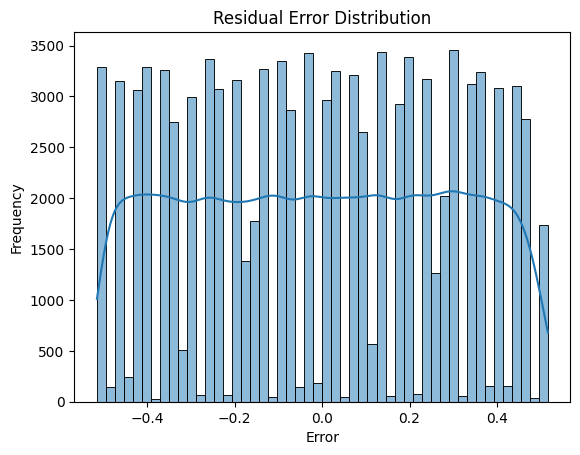

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(errors, bins=50, kde=True)
plt.title("Residual Error Distribution")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.show()


In [47]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=50, learning_rate=0.05, max_depth=3, random_state=42)
gb.fit(X_test.reshape(X_test.shape[0], -1), errors)

error_correction = gb.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_corrected = y_pred_lstm.flatten() + error_correction

mse_gb = mean_squared_error(y_test, y_pred_corrected)
print("Hybrid Model (LSTM + Gradient Boosting) MSE:", mse_gb)


Hybrid Model (LSTM + Gradient Boosting) MSE: 0.08569644971323465


In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('LSTM Training vs Validation Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_lstm.flatten(), label="LSTM Predictions", color="red")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("LSTM Predictions vs Actual")
plt.legend()
plt.show()


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_lstm.flatten(), label="LSTM Predictions", color="red", linestyle='dashed')
plt.plot(y_pred_corrected, label="LSTM + GB Predictions", color="green")
plt.xlabel("Time Steps")
plt.ylabel("Values")
plt.title("LSTM vs. LSTM + Gradient Boosting")
plt.legend()
plt.show()


In [49]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(seq_length, X.shape[2])),
    MaxPooling1D(pool_size=2),
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])

model.compile(optimizer='adam', loss='mse')


In [ ]:
history = model.fit(
    X_train, y_train,  
    validation_data=(X_test, y_test),  
    epochs=20,  # Adjust based on performance  
    batch_size=64,  # Reduce if memory issues occur  
    verbose=1  
)


In [ ]:
from sklearn.metrics import mean_squared_error

y_pred_cnn_lstm = model.predict(X_test)  # Make predictions
mse_cnn_lstm = mean_squared_error(y_test, y_pred_cnn_lstm.flatten())

print("Hybrid Model (CNN + LSTM) MSE:", mse_cnn_lstm)


In [ ]:
errors = y_test - y_pred_cnn_lstm.flatten()

from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
gb.fit(X_test.reshape(X_test.shape[0], -1), errors)

error_correction = gb.predict(X_test.reshape(X_test.shape[0], -1))
y_pred_corrected = y_pred_cnn_lstm.flatten() + error_correction

mse_corrected = mean_squared_error(y_test, y_pred_corrected)
print("Hybrid Model (CNN + LSTM + GB) MSE:", mse_corrected)
